# Imports

In [1]:
pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 23.2 MB/s eta 0:00:00


In [2]:


!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.7 MB/s eta 0:00:00


In [3]:
import requests
import csv
from bs4 import BeautifulSoup
import yfinance as yf
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import math
import warnings
warnings.simplefilter("ignore", UserWarning)
import time

# Analytics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statistics import mean
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ARIMA libraries
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import statsmodels.tsa.arima.model
from pmdarima.arima import auto_arima

# LSTM libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import keras
from tensorflow.keras.models import save_model
from tensorflow.keras.models import model_from_json
from kerastuner.tuners import RandomSearch
from keras.metrics import RootMeanSquaredError
from kerastuner.engine.hyperparameters import HyperParameter
import kerastuner

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio


Using TensorFlow backend


<ipython-input-3-29f54fc22c12>:39: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Data Gathering

## SP500 Tickers

In [4]:
def save_sp500_tickers():
  # Retrieves S&P 500 table from Wikipedia
  URL = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
  res = requests.get(URL)
  soup = BeautifulSoup(res.content, 'lxml')
  table = soup.find('table', {'class': 'wikitable sortable'})

  # Parses the table to a list of ticker symbols
  sp500tickers = []

  for row in table.findAll('tr')[1:]:
      ticker = row.findAll('td')[0].text.strip()
      sp500tickers.append(ticker)

  # Writing to csv
  filename = "sp500tickers.csv"
  with open(filename, mode='w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(['Ticker'])
      for ticker in sp500tickers:
          writer.writerow([ticker])

  return sp500tickers

In [5]:
def load_sp500_tickers():
  path = r'https://raw.githubusercontent.com/jakem08/ms2/main/sp500tickers.csv'
  df = pd.read_csv(path)
  ticker_list = df['Ticker'].tolist()

  return ticker_list


## Stock Data

https://aroussi.com/post/python-yahoo-finance

https://pypi.org/project/yfinance/

In [6]:
def save_stock_data(tickers, start_date, end_date):
  # yahoo finance bulk api call
  data = yf.download(tickers, start=start_date, end=end_date)
  open_df = data.loc[:, 'Open']
  high_df = data.loc[:, 'High']
  low_df = data.loc[:, 'Low']
  close_df = data.loc[:, 'Close']
  adj_close_df = data.loc[:, 'Adj Close']
  volume_df = data.loc[:, 'Volume']

  # yahoo finance individual stock .info
  desc_df = pd.DataFrame()
  for ticker in tqdm(tickers):
    stock_data = yf.Ticker(ticker)
    info = pd.DataFrame([stock_data.info])
    info.index = [ticker]
    desc_df = pd.concat([desc_df,info], axis=0)
    time.sleep(.1)

  # save dataframes to csv
  dataframe_list = [open_df, high_df, low_df, close_df, adj_close_df, volume_df, desc_df]
  names = ['open_df', 'high_df', 'low_df', 'close_df', 'adj_close_df', 'volume_df','desc_df']

  for name, df in zip(names, dataframe_list):
    df.to_csv(f'{name}.csv', index=True)

  return open_df, high_df, low_df, close_df, adj_close_df, volume_df, desc_df

In [7]:
def load_stock_data():
  names = ['open_df', 'high_df', 'low_df', 'close_df', 'adj_close_df', 'volume_df', 'desc_df']
  stock_data = {name: pd.read_csv(f'https://raw.githubusercontent.com/jakem08/ms2/main/{name}.csv',index_col=0) for name in names}
  for df in stock_data.values():
        df.fillna(method='ffill', inplace=True)
  open_df = stock_data['open_df']
  high_df = stock_data['high_df']
  low_df = stock_data['low_df']
  close_df = stock_data['close_df']
  adj_close_df = stock_data['adj_close_df']
  volume_df = stock_data['volume_df']
  desc_df = stock_data['desc_df']

  return open_df, high_df, low_df, close_df, adj_close_df, volume_df, desc_df


# Save or Load Data

Save or Load Tickers

In [8]:
sp500tickers_list = load_sp500_tickers()


Save or Load Stock Data

In [9]:
open_df, high_df, low_df, close_df, adj_close_df, volume_df, desc_df = load_stock_data()

# Data Cleaning


In [10]:
adj_close_df = adj_close_df.drop(['BF.B','BRK.B'], axis=1) #drop BF.B, BRK.B; all NaNs
desc_df = desc_df.drop(['BF.B','BRK.B','CAT','L'], axis=0) #drop BF.B, BRK.B; all NaNs
adj_close_df.tail()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-23 00:00:00,119.129997,14.78,181.119995,147.080002,128.130005,105.129997,75.400002,315.339996,530.710022,176.640335,...,96.080002,57.005459,107.150002,37.779999,100.245552,128.796585,114.849998,270.089996,33.980000,184.250000
2023-08-24 00:00:00,119.489998,14.57,176.380005,146.630005,124.720001,103.750000,75.410004,314.140015,512.429993,172.868271,...,95.489998,56.500019,106.349998,37.240002,99.328522,128.935928,114.320000,265.920013,34.470001,181.559998
2023-08-25 00:00:00,119.680000,14.58,178.610001,146.690002,125.790001,104.209999,74.620003,318.760010,525.059998,177.317123,...,95.480003,57.064922,108.250000,37.529999,100.843613,129.135010,115.239998,268.390015,34.130001,182.820007
2023-08-28 00:00:00,119.919998,14.73,180.190002,147.429993,126.154999,102.790001,74.190002,320.910004,529.919983,179.476868,...,96.790001,57.332504,109.160004,37.650002,101.491516,129.309998,117.529999,269.920013,34.900002,186.979996
2023-08-29 00:00:00,122.019997,14.90,184.119995,147.589996,132.250000,103.870003,75.750000,323.450012,540.570007,181.696304,...,98.070000,57.431610,109.809998,37.790001,101.960007,128.899994,119.230003,273.489990,35.439999,192.770004


In [11]:
# split dataset into 5 sections for cross-validation
adj_close_df_f1 = adj_close_df[:int(len(adj_close_df)*0.2)]
adj_close_df_f2 = adj_close_df[int(len(adj_close_df)*0.2):int(len(adj_close_df)*0.4)]
adj_close_df_f3 = adj_close_df[int(len(adj_close_df)*0.4):int(len(adj_close_df)*0.6)]
adj_close_df_f4 = adj_close_df[int(len(adj_close_df)*0.6):int(len(adj_close_df)*0.8)]
adj_close_df_f5 = adj_close_df[int(len(adj_close_df)*0.8):]
cv_dfs = [adj_close_df_f1,adj_close_df_f2,adj_close_df_f3,adj_close_df_f4,adj_close_df_f5]

# LSTM

In [29]:
# Download actual price data
stock = 'PEAK'
data = yf.download(stock, start = '2021-08-27', end = '2023-09-13')
data = data['Adj Close']
data = data.dropna()

[*********************100%%**********************]  1 of 1 completed


In [36]:
dataset = data.values
dataset = np.reshape(dataset,(dataset.shape[0], 1))
training_data_len = 507

In [37]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)

In [38]:
# Training data
train_data = scaled_data[0:int(training_data_len), :]

In [41]:
# Split training data into features and target
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

# Create numpu arrays with x train and y train
x_train = np.array(x_train)
y_train = np.array(y_train)

# Convert x train to 3D
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# test data
test_data = scaled_data[training_data_len - 60:, :]

x_test = []
y_test = []

for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])
  y_test.append(test_data[i,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = np.array(y_test)

In [42]:
def build_model(hp):
  model = Sequential()
  model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
  for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
  model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
  model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.8,step=0.1)))
  model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
  model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])

  return model

In [43]:
# build a tuner object
from keras.metrics import RootMeanSquaredError as rmse
LOG_DIR = f"{int(time.time())}"

tuner= RandomSearch(

        build_model,
        objective=kerastuner.Objective("mse", direction = "min"),
        max_trials=2,
        executions_per_trial=1,
        directory = LOG_DIR
        )

In [44]:
# build a tuner object
from keras.metrics import RootMeanSquaredError as rmse
LOG_DIR = f"{int(time.time())}"

tuner= RandomSearch(

        build_model,
        objective=kerastuner.Objective("mse", direction = "min"),
        max_trials=3,
        executions_per_trial=1,
        directory = LOG_DIR
        )

In [45]:
 tuner.search(
              x=x_train,
              y=y_train,
              epochs=7,
              batch_size=64,
              validation_data=(x_test,y_test))

Trial 3 Complete [00h 02m 32s]
mse: 0.007079144008457661

Best mse So Far: 0.007079144008457661
Total elapsed time: 00h 06m 54s


In [46]:
# create best model

best_model = tuner.get_best_models(num_models=1)[0]

# get predictions

predictions=best_model.predict(x_test)

# scale predictions back to original form
predictions = scaler.inverse_transform(predictions)
y_test = np.asarray(y_test).reshape(-1,1)
y_test = scaler.inverse_transform(y_test)

1/1 [==============================] - 2s 2s/step


In [47]:
print(y_test)

[[20.39999962]
 [20.40999985]
 [20.12999916]
 [20.02000046]
 [19.76000023]
 [19.93000031]]


# ARIMA

In [51]:
# create a function to calculate returns
def calc_return(df, lag=1):

    prevClose = [x for x in df[ticker_symbol][:-lag]]
    prevClose = [np.nan for i in range(lag)] + prevClose
    df[f'{lag}-day prevClose'] = prevClose
    df['return'] = np.log(df[ticker_symbol] / df[f'{lag}-day prevClose']).shift(1)

    return df

In [78]:
ticker_symbol = 'PEAK'
df = pd.DataFrame(data = data)
scaler = MinMaxScaler(feature_range = (0,1))
df = scaler.fit_transform(df)
df = pd.DataFrame(data = df)
df.columns = [ticker_symbol]

In [80]:
return_df = calc_return(df, lag=1)
# train test split
df = return_df['return'].dropna()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [92]:
train_data, test_data = df[0:505], df[505:]
train_data = train_data.replace([np.inf, -np.inf], 1)

In [87]:
# search for optimal pq
model = auto_arima(train_data, start_p=1, start_q=1,
                    test='adf',
                    max_p=9, max_q=9,
                    d=1,
                    seasonal=False,
                    start_P=0,
                    D=None,
                    trace=True,
                    suppress_warnings=True,
                    stepwise=True)

# fit the model based on optimal hyperparameters from above test
model = statsmodels.tsa.arima.model.ARIMA(train_data, order=(model.order[0], model.order[1], model.order[2]))
fitted = model.fit()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=474.732, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=373.010, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=472.732, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=271.036, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=195.321, Time=0.47 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=175.600, Time=0.92 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=144.310, Time=0.92 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=131.180, Time=1.36 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=128.905, Time=0.75 sec
 ARIMA(8,1,0)(0,0,0)[0] intercept   : AIC=122.337, Time=0.73 sec
 ARIMA(9,1,0)(0,0,0)[0] intercept   : AIC=120.236, Time=1.03 sec
 ARIMA(9,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.65 sec
 ARIMA(8,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.95 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [95]:
fc= fitted.forecast(len(test_data))
test_dates = data.tail(6)
fc.index = test_dates.index

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [111]:
fc = np.array(fc)
fc = np.reshape(fc, (fc.shape[0],1))

In [113]:
arima_predictions = scaler.inverse_transform(fc)
arima_predictions

array([[19.4760534 ],
       [19.84289031],
       [20.48378412],
       [19.96956462],
       [19.62927485],
       [19.72015639]])

# GBM

In [121]:
stock = 'PEAK'
data = data.tail(8)

In [122]:
T = len(data)                         # the amount of time data we have
dt = 1.0 / T                          # this will give equal parts for the time step
t = np.arange(dt, 1 + dt, dt)         # Start at dt because Y = X0 at t = 0
lr = np.log( data / data.shift(1))    # log returns
mu = np.cumsum(lr)                    # cumulative sum of the log returns
sigma = [lr[:x].std() for x in range (1, len(lr)+1)] # standard deviation by step
X0 = data[0]                          # stock price at beginning of time series
Y = []

In [123]:
# Calculate average GBM price path

def calculate_average_simulation_value(nested_list):
  """Calculates the average simulation value for the stock price for each day.

  Args:
    nested_list: A nested list containing simulations of stock prices.

  Returns:
    A list of the average simulation values for the stock price for each day.
  """

  # Create a NumPy array of the nested list
  array = np.array(nested_list)

  # Calculate the average simulation value for the stock price for each day
  average_simulation_values = np.mean(array, axis=0)

  return average_simulation_values

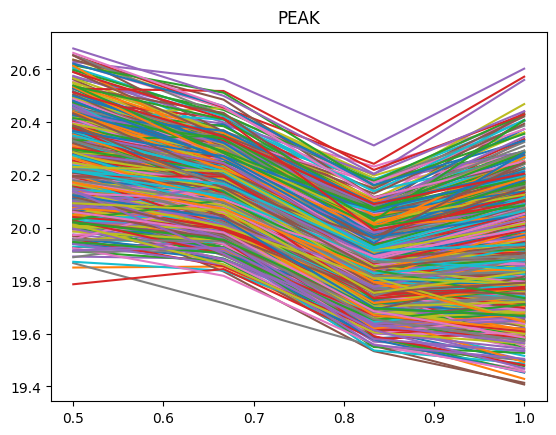

In [124]:
# Simulate and plot 1000 iterations of GBM price paths
for i in range (10**3):
  dB = np.sqrt(dt) * np.random.randn(T) # change in Brownian motion
  B = np.cumsum(dB)
  y = [X0 * np.exp((mu[x] - 0.5 * sigma[x]**2) * t[x] + sigma[x] * B[x]) for x in range(len(mu))]
  plt.plot(t,y)
  plt.title(f'{stock}')
  Y.append(y)

In [127]:
average_GBM = calculate_average_simulation_value(Y)

In [128]:
average_GBM

array([        nan,         nan, 20.26369473, 20.14727579, 19.8649741 ,
       19.92570149])

# Main Plot

In [129]:
data

Date
2023-09-05    20.400000
2023-09-06    20.410000
2023-09-07    20.129999
2023-09-08    20.020000
2023-09-11    19.760000
2023-09-12    19.930000
Name: Adj Close, dtype: float64

In [137]:
# Plot actual prices vs GBM prices
d = {'Actual PEAK' : data,
     'Average GBM Prices': average_GBM}
df = pd.DataFrame(data = d)

df['ARIMA'] = arima_predictions
df['LSTM'] = predictions
df['XG Boost'] = [20.6865, 20.4731, 20.3659, 20.1519, 20.15196, 19.7842]
df

,Actual PEAK,Average GBM Prices,ARIMA,LSTM,XG Boost
Date,,,,,
2023-09-05,20.400000,NaN,19.476053,20.708309,20.68650
2023-09-06,20.410000,NaN,19.842890,20.710003,20.47310
2023-09-07,20.129999,20.263695,20.483784,20.721180,20.36590
2023-09-08,20.020000,20.147276,19.969565,20.739254,20.15190
2023-09-11,19.760000,19.864974,19.629275,20.761055,20.15196
2023-09-12,19.930000,19.925701,19.720156,20.782906,19.78420


In [138]:
import plotly.express as px

fig = px.line(df, x=df.index, y=df.columns[0:5], title='Comparison of Actual vs Predicted Prices for PEAK')
fig.update_layout(legend=dict(
    title="Model"
), yaxis_title="Price ($)")
fig.show()